In [1]:
import sys
import os
import pandas as pd
import numpy as np
import random
import scipy
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import networkx as nx
from scipy import sparse
import hypernetx as hnx

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

source_path = os.path.abspath("../../source/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import hypercore as hc
import matrix as matrix
import centrality as central
import make_core

/home/cstansbu/miniconda3/envs/higher_order/lib/python3.12/site-packages/xgi/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
num_core_nodes = 4
num_periphery_nodes = 15
edge_probability_core = 0.95
edge_probability_periphery = 0.1
avg_edge_size = 3
core_periphery_probability = 0.1

CP = make_core.generate_core_periphery_hypergraph(
    num_core_nodes, num_periphery_nodes, edge_probability_core, 
    edge_probability_periphery, avg_edge_size, core_periphery_probability)

core_nodes, periphery_nodes, edges, incidence_matrix = CP

H = pd.DataFrame(incidence_matrix)
H = H.sample(frac=1, axis=1) 
print(f"{H.shape=}")
print(f"Min Order: {np.min(H.sum(axis=0))}")
H

H.shape=(19, 10)
Min Order: 2


,7,2,8,4,1,5,0,6,9,3
0,0,0,0,0,1,0,0,0,0,0
1,0,1,1,0,1,0,1,1,0,0
2,1,1,0,0,1,1,1,0,0,0
3,0,1,0,1,0,0,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0
9,0,0,1,0,0,0,0,0,0,0


# Plot the Hypergraphs

/home/cstansbu/miniconda3/envs/higher_order/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


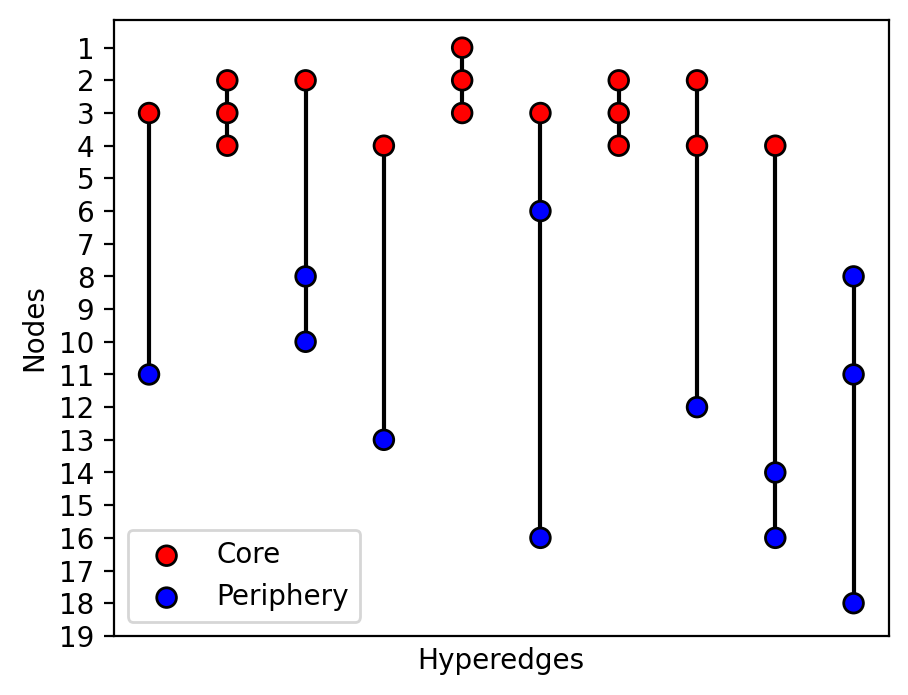

In [3]:
def plot_hypergraph(H, core_nodes=None):
    """
    Plots a hypergraph representation.

    Args:
        H: A pandas DataFrame representing the hypergraph incidence matrix.
        core_nodes: An optional list of node labels considered "core". 
                     These will be highlighted in the plot.
    """

    if core_nodes is None:
        core_nodes = []  # Default to an empty list if not provided

    for i, column in enumerate(H.columns):
        hyperedge = H[column][H[column] > 0]
        order = len(hyperedge)
        x_ind = np.ones(order) * (i + 1)

        c = np.where(hyperedge.index.isin(core_nodes), 'r', 'blue')

        # Plot nodes
        plt.scatter(
            x_ind, 
            hyperedge.index, 
            s=50, 
            c=c, 
            ec='k', 
            zorder=3, 
            label='Core' if c[0] == 'r' else 'Periphery')

        # Plot edges (connecting lines)
        plt.plot(x_ind, hyperedge.index, c='k')

    # Customize axes and labels
    plt.yticks(H.index, H.index + 1)  # Adjust node labels if needed
    plt.xticks([])
    plt.gca().invert_yaxis()
    plt.ylabel('Nodes')
    plt.xlabel('Hyperedges')

    # Add legend 
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='best')
    
    
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 4
plot_hypergraph(H, core_nodes=core_nodes)

# Centrality

In [4]:
ncent, ecent = central.nonlinear_eigenvector_centrality(H.to_numpy(), 
                                                        function='linear', 
                                                        maxiter=1000)
nodes = pd.DataFrame({
    'node' : H.index.to_list(),
    'centrality' : ncent,
})

nodes['core'] = nodes['node'].isin(core_nodes)
nodes.head()

,node,centrality,core
0,0,0.046090,True
1,1,0.243113,True
2,2,0.219271,True
3,3,0.218384,True
4,4,0.000000,False


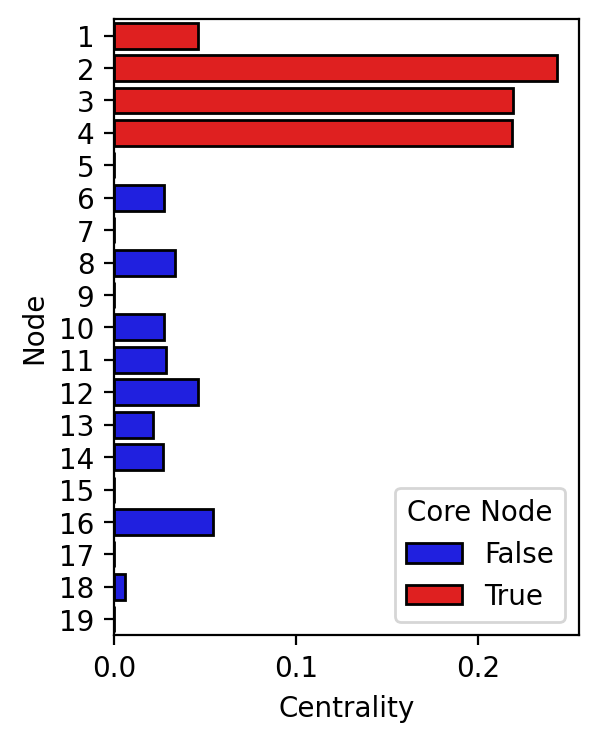

In [5]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 4

sns.barplot(
    data=nodes,
    y='node',
    x='centrality',
    hue='core',
    orient='h',
    ec='k',
    palette=['b', 'r']
)

plt.yticks(H.index, H.index + 1)  # Adjust node labels if needed 
plt.ylabel('Node')
plt.xlabel('Centrality')

sns.move_legend(
    plt.gca(),
    title='Core Node',
    loc='best',
)

# Tudisco and Higham

In [6]:
def tudisco_higham_laplacian(H, f=lambda x: x, g=lambda x: x):
    """
    Computes the generalized nonlinear Laplacian matrix as defined by Tudisco and Higham.

    Args:
        H: A NumPy array representing the incidence matrix of the hypergraph.
        f: A callable function applied element-wise to the transpose of H. Defaults to the identity function.
        g: A callable function applied element-wise to H. Defaults to the identity function.

    Returns:
        L: A NumPy array representing the generalized nonlinear Laplacian matrix.
    """

    Bt = f(H.T)  # Apply f to the transpose of H
    B = g(H)      # Apply g to H

    L = np.dot(B, Bt)           # Compute the Laplacian

    return L

L = tudisco_higham_laplacian(H)

# The Simple Laplacian

L.shape=(19, 19)
[0, 1, 2, 3]


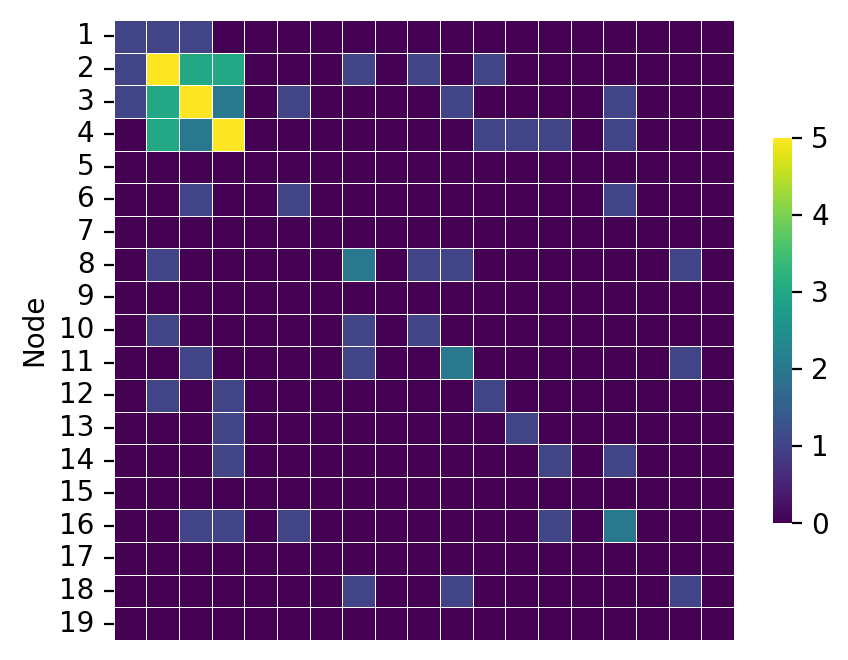

In [7]:
L = tudisco_higham_laplacian(H)
print(f"{L.shape=}")
print(core_nodes)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(
    data=L,
    square=True,
    lw=0.25,
    cbar_kws={'shrink' : 0.5},
    cmap='viridis',
)

_ = plt.yticks(H.index+0.5, H.index + 1.5)  
_ = plt.gca().set_yticklabels(H.index+1)  
plt.ylabel("Node")
_ = plt.xticks([])  

First non-trivial eigenvalue: 10


Text(0, 0.5, 'Magnitude')

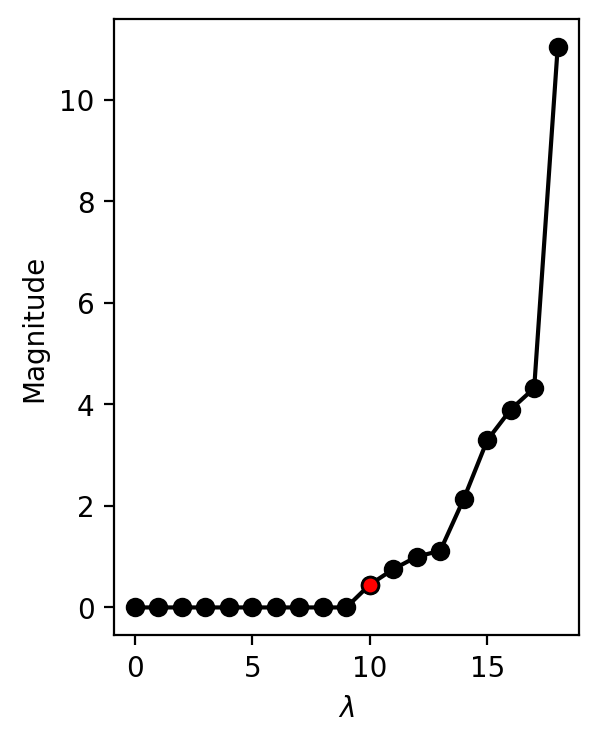

In [8]:
def first_nontrivial(arr, tolerance=1e-8):
    """
    Finds the index of the first value in a sorted array that is strictly greater than the given tolerance.

    Args:
        arr: The sorted array to search.
        tolerance: The tolerance value.

    Returns:
        The index of the first value above the tolerance, or -1 if no such value is found.
    """
    for i, val in enumerate(arr):
        if val > tolerance:
            return i
    return -1

eigenvalues, eigenvectors = np.linalg.eigh(L)
fnt_eig = first_nontrivial(eigenvalues)
print(f"First non-trivial eigenvalue: {fnt_eig}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 4

plt.plot(
    eigenvalues,
    c='k',
    marker="o",
)

plt.scatter(
    fnt_eig,
    eigenvalues[fnt_eig],
    marker="o",
    c='r',
    ec='k',
    zorder=10,
)

plt.xlabel(r"$\lambda$")
plt.ylabel("Magnitude")

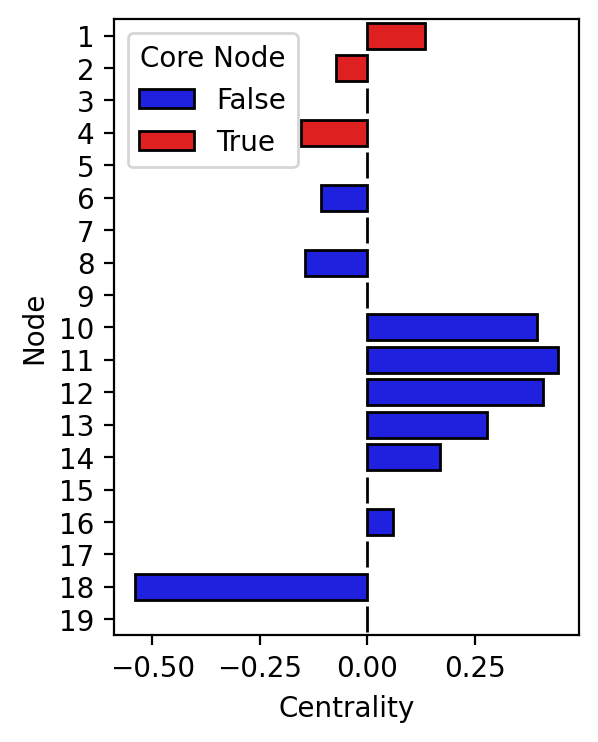

In [9]:
nodes['score'] = np.asarray(eigenvectors[:, fnt_eig]).ravel()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 4

sns.barplot(
    data=nodes,
    y='node',
    x='score',
    hue='core',
    orient='h',
    ec='k',
    palette=['b', 'r']
)

plt.yticks(H.index, H.index + 1)  # Adjust node labels if needed 
plt.ylabel('Node')
plt.xlabel('Centrality')

sns.move_legend(
    plt.gca(),
    title='Core Node',
    loc='best',
)

# Non-linear Laplacian

In [27]:
# def p_norm(vector, p):
#     """
#     Calculates the p-norm of a given vector.

#     Args:
#       vector (numpy.ndarray): The input vector.
#       p (int or float): The order of the norm (p >= 1).

#     Returns:
#       float: The p-norm of the vector.
#     """

#     if p < 1:
#         raise ValueError("p must be greater than or equal to 1")

#     return np.power(np.sum(np.power(np.abs(vector), p)), 1/p)



# def pm_iterator(x, H, objective_function=lambda x: 1 / x, alpha=10):
#     """
#     Performs one iteration of the power method for a hypergraph represented by its incidence matrix H.

#     Args:
#         x (numpy.ndarray): The current iterate of the power method.
#         H (numpy.ndarray): The incidence matrix of the hypergraph.
#         objective_function (callable, optional): Function to be applied to hyperedge sizes. Defaults to lambda x: 1 / x.
#         alpha (int, optional): Parameter for the power method. Defaults to 10.

#     Returns:
#         numpy.ndarray: The next iterate of the power method.
#     """

#     weights = H.sum(axis=0)  # Sum along columns to get hyperedge weights
#     hyperedge_sizes = H.sum(axis=1)  # Sum along rows to get hyperedge sizes

#     y = np.abs(x) ** (alpha - 2) * x
#     z = H @ (weights * objective_function(hyperedge_sizes) * (H.T @ np.abs(x) ** alpha) ** (1 / alpha - 1))

#     return y * z

# def Hypergraph_NSM(H, ϑ=lambda x: 1/x, α=10, p=11, tol=1e-8, x0="ones", verbose=False, maxiter=200):
#     """
#     Compute x with nonnegative entries that maximizes
#     f(x) = sum_{e ∈ E} w(e)ϑ(e) μ_e(x)
#     """

#     n = len(H)

#     if x0 == "ones":

#         x0 = np.ones((n, 1))  # Assuming you have NumPy imported as np

#     if verbose:
#         print("Nonlinear Power Method for Hypergraph CP:")
#         print("-------------------------------")
#         print(f"alpha:\t\t{α}\np:\t\t\t{p}\ntol:\t\t{tol}")

#     pp = p / (p - 1)
#     print(pp)
#     x_array = x0 / p_norm(x0, pp)
#     er_array = []

#     for k in range(1, maxiter + 1):
#         y = pm_iterator(x0.flatten(), H, ϑ, α)  # Assuming pm_iterator takes a flattened array
#         y = y / p_norm(y, pp)
#         x = y ** (pp / p)
#         x_array = np.hstack((x_array, x.reshape(-1, 1)))  # Reshape x to ensure it's a column vector
#         er_array.append(np.linalg.norm(x - x0))
#         if er_array[-1] < tol or np.isnan(er_array[-1]):
#             if verbose:
#                 print(f"Num iter:\t{k}")
#             break
#         else:
#             x0 = x.copy()

#     return x_array[:, -1], x_array, er_array

# Hypergraph_NSM(H)

1.1


ValueError: matrices are not aligned

In [13]:
p = 11
q = 10
g = lambda x: x ** (-1 + 1/q)
f = lambda x: x ** (q/(p-q))

L = tudisco_higham_laplacian(H, f=f, g=g)
print(L)
# print(f"{L.shape=}")
# print(core_nodes)

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 5, 5

# sns.heatmap(
#     data=L,
#     square=True,
#     lw=0.25,
#     cbar_kws={'shrink' : 0.5},
#     cmap='viridis',
# )

# _ = plt.yticks(H.index+0.5, H.index + 1.5)  
# _ = plt.gca().set_yticklabels(H.index+1)  
# plt.ylabel("Node")
# _ = plt.xticks([])  

[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan]
 [nan nan nan nan nan nan na

In [11]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
eigenvalues, eigenvectors = np.linalg.eigh(L)
fnt_eig = first_nontrivial(eigenvalues)
print(f"First non-trivial eigenvalue: {fnt_eig}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 4

plt.plot(
    eigenvalues,
    c='k',
    marker="o",
)

plt.scatter(
    fnt_eig,
    eigenvalues[fnt_eig],
    marker="o",
    c='r',
    ec='k',
    zorder=10,
)

plt.xlabel(r"$\lambda$")
plt.ylabel("Magnitude")

In [ ]:
nodes['score'] = np.asarray(eigenvectors[:, fnt_eig]).ravel()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 4

sns.barplot(
    data=nodes,
    y='node',
    x='score',
    hue='core',
    orient='h',
    ec='k',
    palette=['b', 'r']
)

plt.yticks(H.index, H.index + 1)  # Adjust node labels if needed 
plt.ylabel('Node')
plt.xlabel('Centrality')

sns.move_legend(
    plt.gca(),
    title='Core Node',
    loc='best',
)

In [ ]:
break

# The Higher-Order Laplacian

In [ ]:
L = matrix.normalized_hypergraph_laplacian(H).todense()
# L = matrix.hypergraph_laplacian(H).todense()
print(f"{L.shape=}")
print(core_nodes)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(
    data=L,
    square=True,
    lw=0.25,
    cbar_kws={'shrink' : 0.5},
    cmap='viridis',
)

_ = plt.yticks(H.index+0.5, H.index + 1.5)  
_ = plt.gca().set_yticklabels(H.index+1)  
plt.ylabel("Node")
_ = plt.xticks([])  

In [ ]:
def first_nontrivial(arr, tolerance=1e-12):
    """
    Finds the index of the first value in a sorted array that is strictly greater than the given tolerance.

    Args:
        arr: The sorted array to search.
        tolerance: The tolerance value.

    Returns:
        The index of the first value above the tolerance, or -1 if no such value is found.
    """
    for i, val in enumerate(arr):
        if val > tolerance:
            return i
    return -1

eigenvalues, eigenvectors = np.linalg.eigh(L)
fnt_eig = first_nontrivial(eigenvalues)
print(f"First non-trivial eigenvalue: {fnt_eig}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

plt.plot(
    eigenvalues,
    c='k',
    marker="o",
)

plt.scatter(
    fnt_eig,
    eigenvalues[fnt_eig],
    marker="o",
    c='r',
    ec='k',
    zorder=10,
)

plt.xlabel(r"$\lambda$")
plt.ylabel("Magnitude")

In [ ]:
nodes['score'] = np.asarray(eigenvectors[:, fnt_eig]).ravel()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 4

sns.barplot(
    data=nodes,
    y='node',
    x='score',
    hue='core',
    orient='h',
    ec='k',
    palette=['b', 'r']
)

plt.yticks(H.index, H.index + 1)  # Adjust node labels if needed 
plt.ylabel('Node')
plt.xlabel('Centrality')

sns.move_legend(
    plt.gca(),
    title='Core Node',
    loc='best',
)

In [ ]:
break

In [ ]:
float(4.29371588e-01)

In [ ]:
break

# clique expansion

In [ ]:
A = matrix.clique_expand_incidence(H, zero_diag=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

sns.heatmap(
    A,
    square=True,
    lw=0.25,
    cbar=False,
    annot=True,
    linecolor='k',
    cmap='Reds',
)

plt.yticks([])
plt.xticks(H.index, H.index + 1)
plt.xlabel('Nodes')

In [ ]:
# break

# Hypergraph plotting

In [ ]:
def to_hypernet(H):
    """A function to convert a dataframe into a 
    hypernet hypergrapgh"""
    
    iteractions = {}
    
    for idx, row in H.T.iterrows():
        iteractions[idx+1] = tuple(row[row == 1].index +1)

    hx = hnx.Hypergraph(iteractions)
    return hx
    

hx = to_hypernet(H)

def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=True,
                 nodes_kwargs={'color' : node_color, 'edgecolor' : 'k',},
                 edges_kwargs={'edgecolors' : 'grey',},
                 layout_kwargs = {'seed' : 39},
                )


# Compute nonlinear node centrality

In [ ]:
ncent, ecent = central.nonlinear_eigenvector_centrality(H.to_numpy(), 
                                                        function='linear', 
                                                        maxiter=1000)
nodes = pd.DataFrame({
    'node' : H.index.to_list(),
    'centrality' : ncent,
})

nodes['core'] = nodes['node'].isin(core_nodes)

nodes = nodes.sort_values(by='centrality', 
                          ascending=False,)
nodes.head()

In [ ]:
edges = pd.DataFrame({
    'edge' : H.columns.to_list(),
    'centrality' : ecent,
})

core_edges = np.where(H.iloc[core_nodes, :].any() == 1)[0]

edges['core'] = edges['edge'].isin(core_edges)

edges = edges.sort_values(by='centrality', 
                          ascending=False,)
edges.head(10)

# Plot centralities

In [ ]:
colors = plt2.floats_to_colors(ncent, colormap='Reds')

def node_color(v):
    return colors[v, :]


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=True,
                 node_radius=2,
                 nodes_kwargs={'color': node_color, 'ec' : 'k'},
                 edges_kwargs={'edgecolors': 'grey',},
                 layout_kwargs = {'seed': 39},
                )

In [ ]:
reload(plt2)
plt2.make_colorbar(cmap='Reds')

In [ ]:
# colors = plt2.floats_to_colors(ecent, colormap='viridis')

# def node_color(v):
#     if v in core_nodes:
#         return 'r'
#     else:
#         return 'b'

# def edge_color(v):
#     return colors[v, :]


# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 6, 6

# hnx.drawing.draw(hx, 
#                  with_node_counts=False, 
#                  with_edge_counts=False,
#                  with_edge_labels=False, 
#                  with_node_labels=False,
#                  nodes_kwargs={'color': node_color, 'ec' : 'k'},
#                  edges_kwargs={'edgecolors': 'k', 
#                                'linewidths' : 1, 
#                                'facecolors': edge_color, 
#                                'alpha' : 0.25},
#                  layout_kwargs = {'seed': 39},
#                 )

In [ ]:
reload(plt2)
plt2.make_colorbar()

# Is there a principaled way to "discover" this threshold?

In [ ]:
"""choosing from node centralities only"""

n_bins = 20
res = []

for n_t in np.linspace(0, 1, n_bins):
    node_idx = np.argwhere(ncent >= n_t).ravel()
    core = H.iloc[node_idx]
    
    # remove non-existant edges
    core = core.loc[:, (core.sum(axis=0) != 0)]

                
    if core.empty:
        continue
        
    try:
        L = matrix.normalized_hypergraph_laplacian(core).todense()        
        eigenvalues, eigenvectors = np.linalg.eigh(L)
        fiedler_number = eigenvalues[1]
    except:
        fiedler_number = None

    row = {
        'node_thresh' : n_t,
        'n_nodes' : len(node_idx),
        'core_nodes' : node_idx,
        'fiedler_number' : fiedler_number,
    }
    res.append(row)
            
    
res = pd.DataFrame(res)
res = res.sort_values(by='fiedler_number', ascending=False)
res.head()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

sns.lineplot(data=res,
             x='node_thresh',
             y='fiedler_number')

max_value_row = res.loc[res['fiedler_number'].idxmax()]

plt.scatter(
    max_value_row['node_thresh'],
    max_value_row['fiedler_number'],
    c='r',
    ec='k',
    zorder=5,
)

plt.ylabel('Core Fiedler Number')
plt.xlabel('Node Centrality Threshold')

# Archive 

In [ ]:
break

# sparse hypergraph with core periphery structure

In [ ]:

# Example usage
num_core_nodes = 3
num_periphery_nodes = 15
edge_probability_periphery = 0.1
avg_edge_size = 3
core_periphery_probability = 0.25

core_nodes, periphery_nodes, edges, incidence_matrix = generate_core_periphery_hypergraph(
    num_core_nodes, num_periphery_nodes, edge_probability_core, 
    edge_probability_periphery, avg_edge_size, core_periphery_probability)

H = pd.DataFrame(incidence_matrix)
print(f"{H.shape=}")
H.head()

In [ ]:
hx = to_hypernet(H)

def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'
    
    
px = 0.2
    
def edge_color(v):
    rand = np.random.random()
    if rand > px:
        return 'none'
    else:
        return 'grey'
    
        

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=False,
                 nodes_kwargs={'color': node_color, 'edgecolor' : 'k'},
                 edges_kwargs={
                     'edgecolors': 'k', 
                     'lw' : 1, 
                     'facecolors': edge_color, 
                     'alpha' : 0.15,
                 },
                 layout_kwargs = {'seed': 39},
                )

In [ ]:
hx = to_hypernet(H)

def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'
    
    
px = 0.2
    
def edge_color(v):
    rand = np.random.random()
    if rand > px:
        return 'none'
    else:
        return 'grey'
    
        

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=False,
                 nodes_kwargs={'color': node_color, 'edgecolor' : 'k'},
                 edges_kwargs={
                     'edgecolors': edge_color, 
                     'lw' : 1, 
                 },
                 layout_kwargs = {'seed': 39},
                )

In [ ]:
break

In [ ]:
"""Choosing from both thresholds """

print(f"{H.shape=}")

res = []

for n_t in ncent:
    node_idx = np.argwhere(ncent >= n_t).ravel()
    
    for e_t in ecent:
        edge_idx = np.argwhere(ecent >= e_t).ravel()
        core = H.iloc[node_idx][edge_idx]
        
        if core.empty:
            continue
        
        try:
            L = matrix.normalized_hypergraph_laplacian(core).todense()        
            eigenvalues, eigenvectors = np.linalg.eigh(L)
            fiedler_number = eigenvalues[1]
        except:
            fiedler_number = None
        
        row = {
            'node_thresh' : n_t,
            'edge_thresh' : e_t,
            'n_nodes' : len(node_idx),
            'n_edges' : len(edge_idx),
            'core_nodes' : node_idx,
            'core_edges' : edge_idx,
            'fiedler_number' : fiedler_number,
        }
        res.append(row)
        
res = pd.DataFrame(res)
res = res.sort_values(by='fiedler_number', ascending=False)
res.head()

In [ ]:
res[(res['n_nodes'] == 4) & (res['n_edges'] == 3)]

In [ ]:
res[(res['node_thresh'] > 0.102)  & (res['edge_thresh'] > 0.147)]

In [ ]:
break

# Archive

In [ ]:
# def plot_core_periphery_networkx(core_nodes, periphery_nodes, edges):
#     """
#     This function plots a core-periphery network using NetworkX for layout and Matplotlib for visualization.

#     Args:
#       core_nodes: List of core nodes.
#       periphery_nodes: List of periphery nodes.
#       edges: List of lists, where each inner list represents an edge in the hypergraph.
#     """
#     plt.figure(figsize=(8, 6))

#     # Create a NetworkX graph
#     G = nx.Graph()

#     # Add nodes with color distinction for core and periphery
#     G.add_nodes_from(core_nodes, color='red')
#     G.add_nodes_from(periphery_nodes, color='blue')

#     # Add edges
#     for edge in edges:
#         for i in range(len(edge) - 1):
#             G.add_edge(edge[i], edge[i + 1])

#     # Use a layout algorithm for node positioning (adjust as needed)
#     pos = nx.spring_layout(G)

#     # Draw the graph with node colors and positions
#     nx.draw_networkx_nodes(G, pos, nodelist=periphery_nodes, node_color='blue', node_size=150, edgecolors='k')
#     nx.draw_networkx_nodes(G, pos, nodelist=core_nodes, node_color='red', node_size=350, edgecolors='k')
#     nx.draw_networkx_edges(G, pos, alpha=0.7, width=1.5)

#     # Labels and title
#     plt.axis('off')
#     plt.show()
    
# plt.rcParams['figure.dpi'] = 200
# plot_core_periphery_networkx(core_nodes, periphery_nodes, edges)

In [ ]:
break